In [2]:
import functionlib as fl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
def payoff_barrier_option(path, K, T, B, option_type, observ_freq=1, graph=False):
    """
    Computes the payoff of a barrier option given a price path. 
    Option type can be: upincall, upoutcall, upinput, upoutput, downincall, downoutcall, downinput, downoutput
    Observation are made every observ_freq days.
    """
    
    #if path.shape[1] > 1:
        #raise ValueError("Path contains more than 1 simulation")



    if graph:
        plt.figure(figsize=(10,6))
        plt.plot(path)
        plt.axhline(y = B, color='r', linestyle='--')
        plt.text(0, B+0.2, 'BARRIER', color='r')
        plt.xlabel('Time (days)')
        plt.ylabel('Index level')
        plt.grid()
        plt.show()



    time_steps = T*252
    observation_dates = np.arange(observ_freq, time_steps+1, observ_freq)

    path_at_observation = [path.iloc[observation-1].values for observation in observation_dates]
    
    max_price = max(path_at_observation)
    min_price = min(path_at_observation)

    S_T = path.iloc[-1].values

    payoff = 0

    if option_type == 'upincall':
        if max_price >= B: #Barrier reached, standard call payoff
            return max(S_T-K, 0)
        else:
            return 0
        
    elif option_type == 'upinput': #Barrier reached, standard put payoff
        if max_price >= B:
            return max(K-S_T,0)
        else:
            return 0
    
    elif option_type == 'downincall':
        if min_price <= B: #Barrier reached, standard call payoff
            return max(S_T-K,0)
        else:
            return 0

    elif option_type == 'downinput':
        if min_price <= B:
            return max(K-S_T,0)
        else:
            return 0
        
    """
    All Knock-In cases are treated, to compute the payoff for Knock-Out options,
    we use parity relationhip: KO + KI = Vanilla
    """

    if option_type == 'upoutcall':
        return max(S_T-K) - payoff_barrier_option(path, K, T, B, option_type='upincall', observ_freq=observ_freq)
    
    elif option_type == 'upoutput':
        return max(K-S_T) - payoff_barrier_option(path, K, T, B, option_type='upinput', observ_freq=observ_freq)
    
    elif option_type == 'downoutcall':
        return max(S_T-K) - payoff_barrier_option(path, K, T, B, option_type='downincall', observ_freq=observ_freq)
    
    else:
        return max(K-S_T) - payoff_barrier_option(path, K, T, B, option_type='downinput')
    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


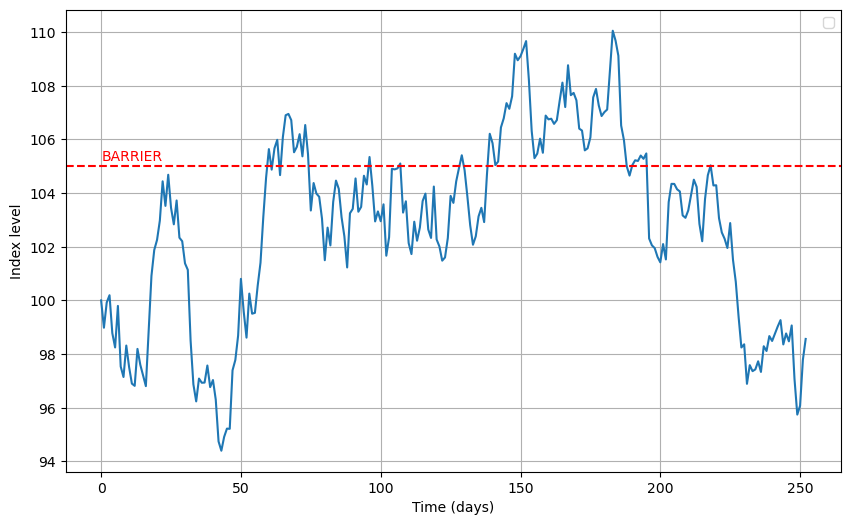

In [8]:
S0 = 100
T = 1
r = 0.02
vol = 0.15
M = 1

B = 105

path = fl.monte_carlo(S0, T, r, vol, M, antithetic=False)
plt.figure(figsize=(10,6))
plt.plot(path)
plt.axhline(y = B, color='r', linestyle='--')
plt.text(0, B+0.2, 'BARRIER', color='r')
plt.xlabel('Time (days)')
plt.ylabel('Index level')
plt.legend()
plt.grid()
plt.show()

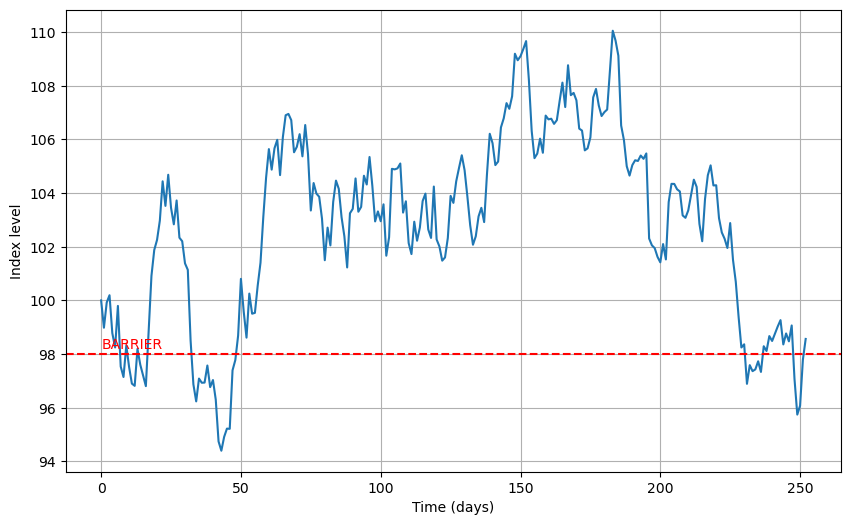

-1.4353282664580433

In [22]:
payoff_barrier_option(path, 100, 1, 98, 'downoutcall', graph=True)

In [ ]:
np.max(path.values, axis=0, keepdims=True)

array([[152.32296663, 100.        ]])

In [ ]:
def barrier_option_price(S0, K, T, r, vol, B, option_type, observ_freq=1, M=1000):

    barrier_payoff = lambda path: payoff_barrier_option(path, K, T, B, observ_freq, option_type)

    path_matrix = fl.monte_carlo(S0, T, r, vol, M, antithetic=False)
    payoff_simulation = [barrier_payoff(path_matrix.iloc[:,i].to_frame()) for i in range(path_matrix.shape[1])]

    
    

In [ ]:
barrier_payoff = lambda path: payoff_barrier_option(path, 100, 1, 105, option_type='upincall')
path_matrix = fl.monte_carlo(S0, T, r, vol, 1000)
payoff_simulation = np.array([barrier_payoff(path_matrix.iloc[:,i].to_frame()) for i in range(path_matrix.shape[1])])
np.exp(-r*T)*payoff_simulation.mean()


NameError: name 'fl' is not defined